In [ ]:
! nvidia-smi

Fri Jun 23 13:04:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

import utils
import model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

mean, std = utils.get_mean_and_std(exp_data)

print("Mean of the CIFAR10 dataset ", mean)
print("Standard Deviation of the CIFAR10 dataset ", std)

100%|██████████| 170498071/170498071 [00:10<00:00, 16566043.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
 - Dataset Numpy Shape: (50000, 32, 32, 3)
 - Min: [0. 0. 0.]
 - Max: [1. 1. 1.]
 - Mean: [0.49139968 0.48215841 0.44653091]
 - Std: [0.24703223 0.24348513 0.26158784]
 - Var: [15.56135559 15.11767693 17.44919073]
Mean of the CIFAR10 dataset  [0.49139968 0.48215841 0.44653091]
Standard Deviation of the CIFAR10 dataset  [0.24703223 0.24348513 0.26158784]


In [ ]:
train_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.4914,0.4822,0.4465], [0.247, 0.243, 0.261])])

test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.4914,0.4822,0.4465], [0.247, 0.243, 0.261])])

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


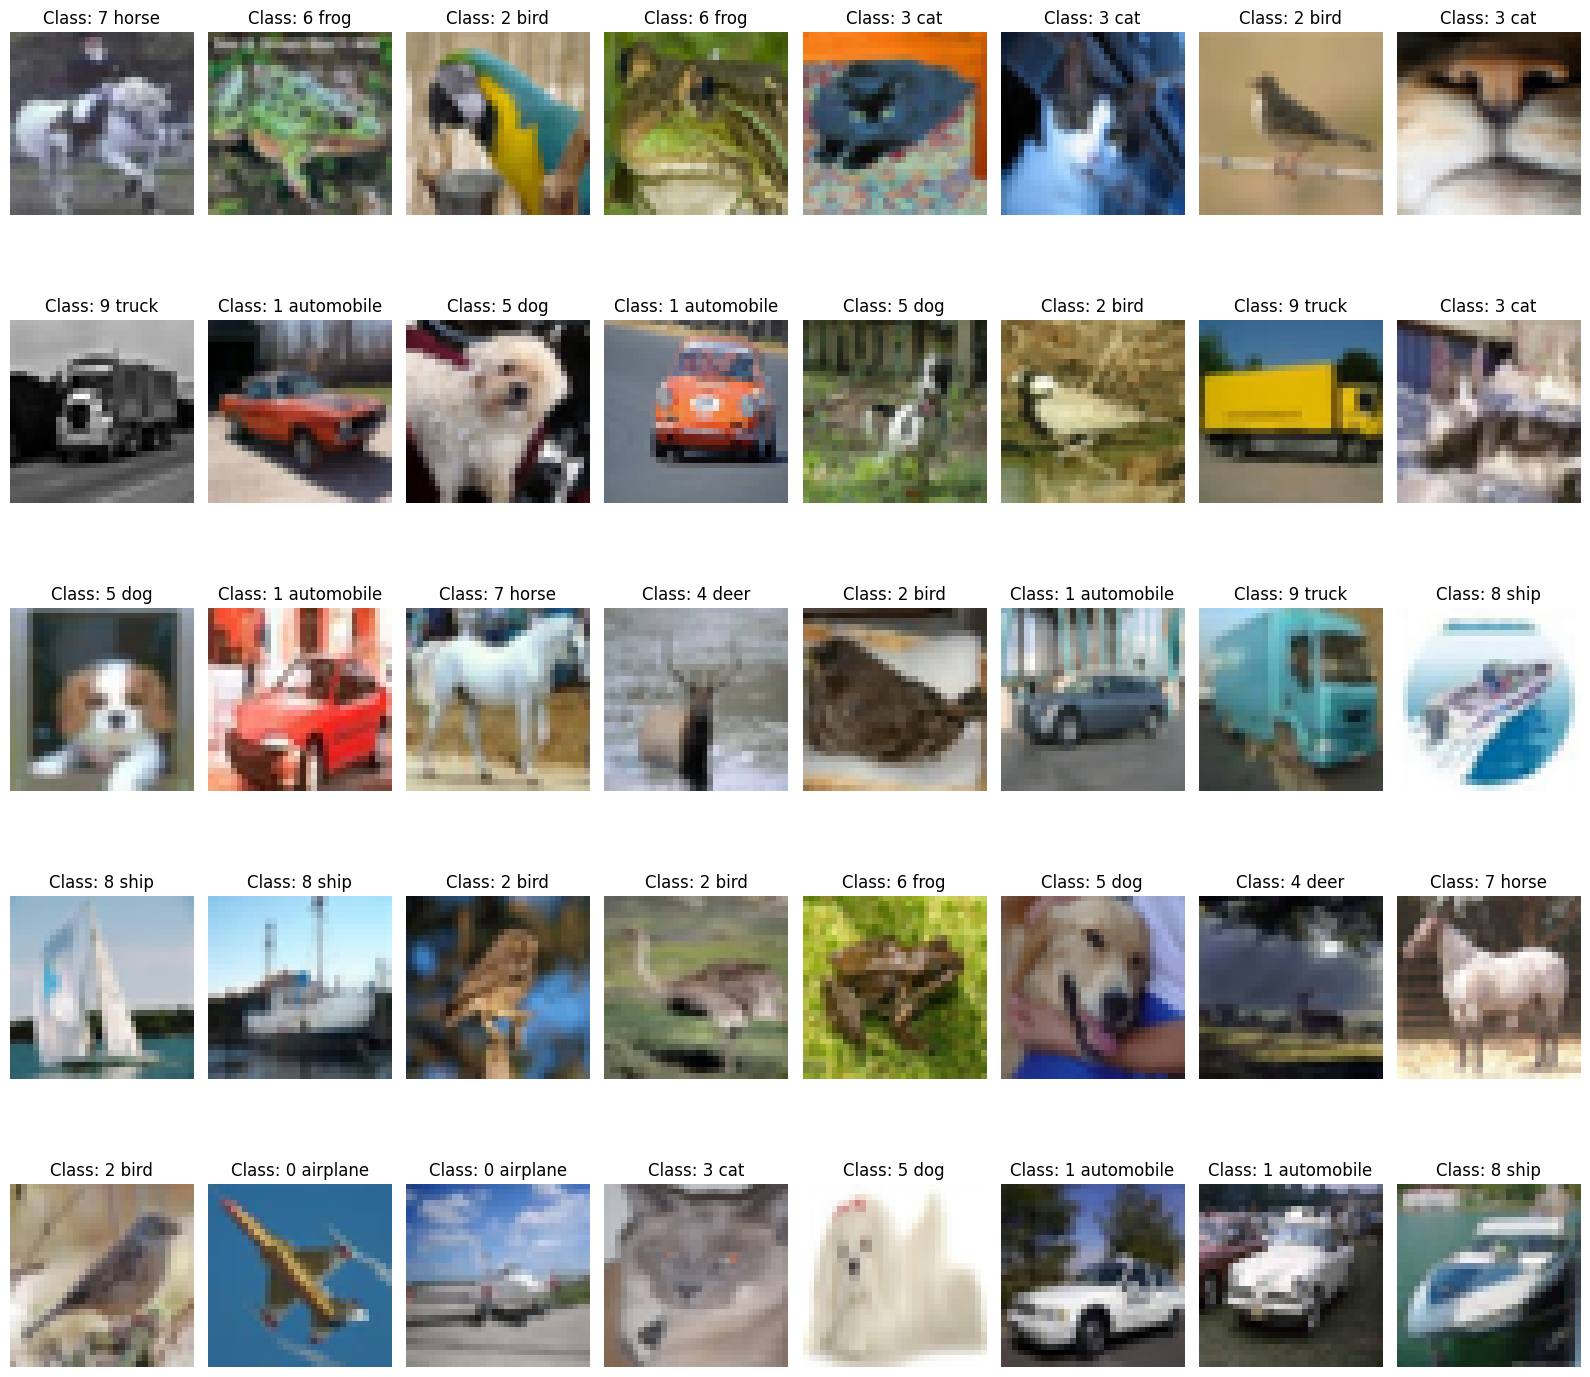

In [ ]:
utils.plot_data(exp,5,8)

In [ ]:
from model import Net
model = Net('bn').to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           1,024
             ReLU-10           [-1, 16, 32, 32]               0
      BatchNorm2d-11           [-1, 16, 32, 32]              32
        MaxPool2d-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           4,608
             ReLU-14           [-1, 32,

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


EPOCH: 1


Loss=1.698671817779541 Batch_id=1562 Accuracy=42.93: 100%|██████████| 1563/1563 [00:29<00:00, 53.17it/s]



Test set: Average loss: 1.3086, Accuracy: 5309/10000 (53.09%)

EPOCH: 2


Loss=1.260350227355957 Batch_id=1562 Accuracy=56.61: 100%|██████████| 1563/1563 [00:29<00:00, 52.92it/s]



Test set: Average loss: 1.0297, Accuracy: 6387/10000 (63.87%)

EPOCH: 3


Loss=0.8445270657539368 Batch_id=1562 Accuracy=62.20: 100%|██████████| 1563/1563 [00:28<00:00, 54.44it/s]



Test set: Average loss: 0.9405, Accuracy: 6700/10000 (67.00%)

EPOCH: 4


Loss=0.8505531549453735 Batch_id=1562 Accuracy=64.95: 100%|██████████| 1563/1563 [00:28<00:00, 54.01it/s]



Test set: Average loss: 0.8668, Accuracy: 6942/10000 (69.42%)

EPOCH: 5


Loss=1.3917077779769897 Batch_id=1562 Accuracy=67.17: 100%|██████████| 1563/1563 [00:28<00:00, 54.01it/s]



Test set: Average loss: 0.8380, Accuracy: 7050/10000 (70.50%)

EPOCH: 6


Loss=0.788830041885376 Batch_id=1562 Accuracy=68.85: 100%|██████████| 1563/1563 [00:28<00:00, 54.15it/s]



Test set: Average loss: 0.8037, Accuracy: 7138/10000 (71.38%)

EPOCH: 7


Loss=1.2575465440750122 Batch_id=1562 Accuracy=70.01: 100%|██████████| 1563/1563 [00:28<00:00, 54.36it/s]



Test set: Average loss: 0.7796, Accuracy: 7253/10000 (72.53%)

EPOCH: 8


Loss=0.6357783079147339 Batch_id=1562 Accuracy=71.14: 100%|██████████| 1563/1563 [00:29<00:00, 53.72it/s]



Test set: Average loss: 0.7990, Accuracy: 7219/10000 (72.19%)

EPOCH: 9


Loss=0.44924864172935486 Batch_id=1562 Accuracy=71.87: 100%|██████████| 1563/1563 [00:29<00:00, 53.11it/s]



Test set: Average loss: 0.7636, Accuracy: 7299/10000 (72.99%)

EPOCH: 10


Loss=0.7655420899391174 Batch_id=1562 Accuracy=72.53: 100%|██████████| 1563/1563 [00:29<00:00, 53.26it/s]



Test set: Average loss: 0.7314, Accuracy: 7413/10000 (74.13%)



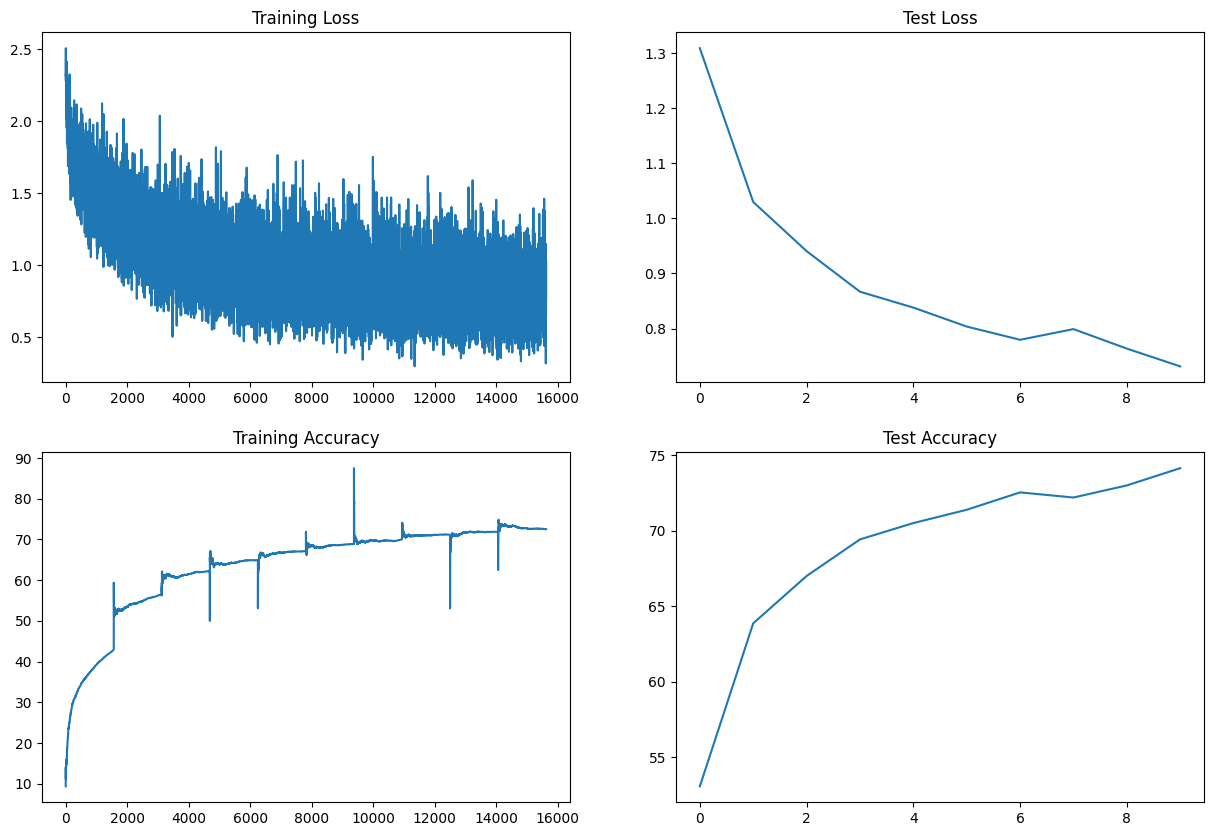

In [ ]:
utils.draw_graphs(train_losses, train_acc, test_losses, test_acc)

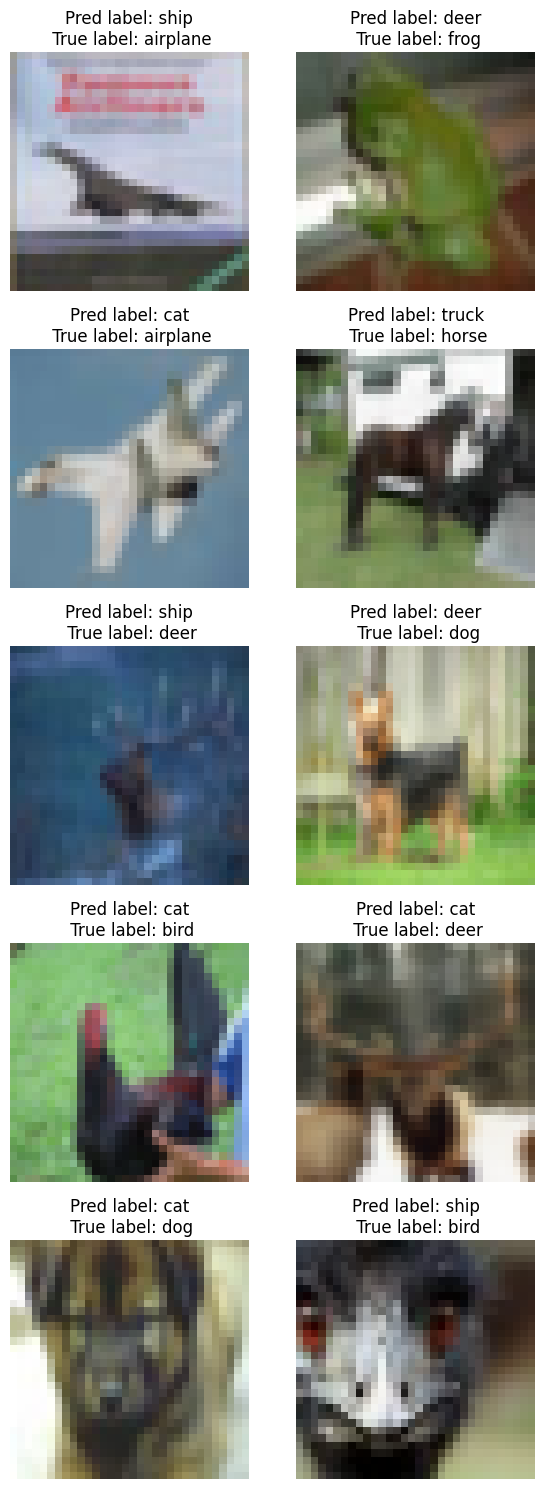

In [ ]:
misclf = utils.plot_misclassified(model, test_loader, testset.classes, device, mean, std, no_misclf=10, plot_size=(5,2), return_misclf=True)